# The `dask` ecosystem

## Matti Lyra

## @mattilyra

# comtravo (yes we are hiring)

# PyData Berlin

## https://pydata.org/berlin2018

1. Intro to `dask`
2. Dask distributed
3. A scalable, on demand, parallel computing infrastucture
  - dask
  - kubernetes

1. Dask https://github.com/dask
    2. `dask`
      - https://github.com/dask/dask
    3. `dask.distributed`
      - https://github.com/dask/distributed
    3. `dask-kubernetes`
      - https://github.com/dask/dask-kubernetes      

    4. dask-ml
    4. dask-searchcv
    5. dask-jobqueue

# dask

In [ ]:
from string import ascii_lowercase
import random
from pathlib import Path
import json
import time
import uuid
from datetime import datetime

months = [f'{i:02d}' for i in range(1, 13)]
days = [f'{i:02d}' for i in range(1, 31)]
hours = [f'{i:02d}' for i in range(0, 24)]
minutes = [f'{i:02d}' for i in range(0, 60)]

def generate_dicts():
    num_dicts = random.randint(5, 50)
    for i in range(num_dicts):
        data = {}
        ts = time.time() - random.randint(0, 3600*24*60)
        dt = datetime.fromtimestamp(ts)
        data['cid'] = ''.join([str(i) for i in random.sample(ascii_lowercase, 5)])
        data['price'] = random.randint(0, 20)
        data['weight'] = random.randint(1, 100)
        data['height'] = random.randint(1, 100)
        data['distance'] = random.randint(0, 1000)
        data['timestamp'] = ts
        data['date'] = dt.strftime('%Y-%m-%dT%H:%M')
        yield data
        
for _ in range(50):
    h, m = random.choice(hours), random.choice(minutes)
    p = Path('./data') / random.choice(months)  / random.choice(days)
    p.mkdir(parents=True, exist_ok=True)
    p = p / f'{uuid.uuid1()}.{h}{m}.json'
    with open(p, 'w') as fh:
        for data in generate_dicts():
            s = json.dumps(data)
            fh.write(f'{s}\n')

In [160]:
!find ./data -name *.json | head

./data/01/09/61a4beae-69b6-11e8-97c7-705681be1265.0644.json
./data/01/14/61ae5d4c-69b6-11e8-aa06-705681be1265.0814.json
./data/01/21/619f8dd0-69b6-11e8-8cbc-705681be1265.1650.json
./data/01/22/61afc790-69b6-11e8-a335-705681be1265.0409.json
./data/01/23/61b13828-69b6-11e8-b1e4-705681be1265.1347.json
./data/01/28/61a910b4-69b6-11e8-bb69-705681be1265.0806.json
./data/02/01/61af2d76-69b6-11e8-9e45-705681be1265.0929.json
./data/02/06/61a3dfe8-69b6-11e8-b1a0-705681be1265.1925.json
./data/02/06/61a50bfa-69b6-11e8-9371-705681be1265.0830.json
./data/02/12/61ab4530-69b6-11e8-9f6b-705681be1265.1430.json


In [161]:
!head -1 ./data/01/09/61a4beae-69b6-11e8-97c7-705681be1265.0644.json

{"cid": "mjhdw", "price": 4, "weight": 2, "height": 95, "distance": 394, "timestamp": 1527112986.7953238, "date": "2018-05-24T00:03"}


In [4]:
import json
from dask import bag as db

db.read_text('./data/01/*/*.json').map(json.loads).take(1)
# db.read_text('s3://./data/01/*/*.json').map(json.loads).take(1)

({'cid': 'bonsu',
  'date': '2018-05-27T16:54',
  'distance': 515,
  'height': 5,
  'price': 14,
  'timestamp': 1527432870.7613099,
  'weight': 40},)

In [5]:
bag = db.read_text('./data/01/*/*.json').map(json.loads)
bag.filter(lambda d: d['height'] > 20).take(1, npartitions=-1)

({'cid': 'izlqr',
  'date': '2018-04-25T12:40',
  'distance': 682,
  'height': 67,
  'price': 12,
  'timestamp': 1524652846.761405,
  'weight': 72},)

In [6]:
from datetime import datetime, date

bag = db.read_text('./data/01/*/*.json').map(json.loads)
bag.filter(lambda d: datetime.fromtimestamp(d['timestamp']).date() < date(2018, 5, 1))\
   .filter(lambda d: datetime.fromtimestamp(d['timestamp']).date() >= date(2018, 4, 1))\
    .take(1, npartitions=-1)

({'cid': 'izlqr',
  'date': '2018-04-25T12:40',
  'distance': 682,
  'height': 67,
  'price': 12,
  'timestamp': 1524652846.761405,
  'weight': 72},)

In [7]:
from datetime import datetime, date
import time

def dummy(d):
    d.update({'distance_km': d['distance'] * 1.609344})
    return d

bag = db.read_text('./data/01/*/*.json').map(json.loads)
bag.filter(lambda d: datetime.fromtimestamp(d['timestamp']).date() < date(2018, 5, 1))\
   .filter(lambda d: datetime.fromtimestamp(d['timestamp']).date() >= date(2018, 4, 1))\
    .map(dummy)\
    .pluck('distance_km').sum().compute()

12258.373248

In [11]:
from datetime import datetime

bag = db.read_text('./data/01/*/*.json').map(json.loads)
bag = bag.pluck('price').frequencies()
bag.compute()

[(4, 7),
 (16, 8),
 (11, 9),
 (6, 3),
 (9, 9),
 (3, 7),
 (2, 6),
 (10, 6),
 (15, 2),
 (18, 13),
 (5, 6),
 (1, 11),
 (13, 5),
 (17, 5),
 (0, 2),
 (19, 3),
 (12, 6),
 (8, 5),
 (20, 9),
 (14, 10),
 (7, 6)]

### Files _must_ be malformed JSON

```
...
{"cid": "mjhdw", "price": 4, "weight": 2, "distance": 394, "date": "2018-05-24T00:03"}
{"cid": "mjhdw", "price": 4, "height": 95, "distance": 394, "date": "2018-05-24T00:03"}
...
```

# There's lots more to `dask` than `bag`s

## dask.array
## dask.dataframe

# `dask.distributed`

---

## Scheduler that enables running `dask` graphs on a cluster of nodes

## http://distributed.readthedocs.io/en/latest/

### dask graphs?

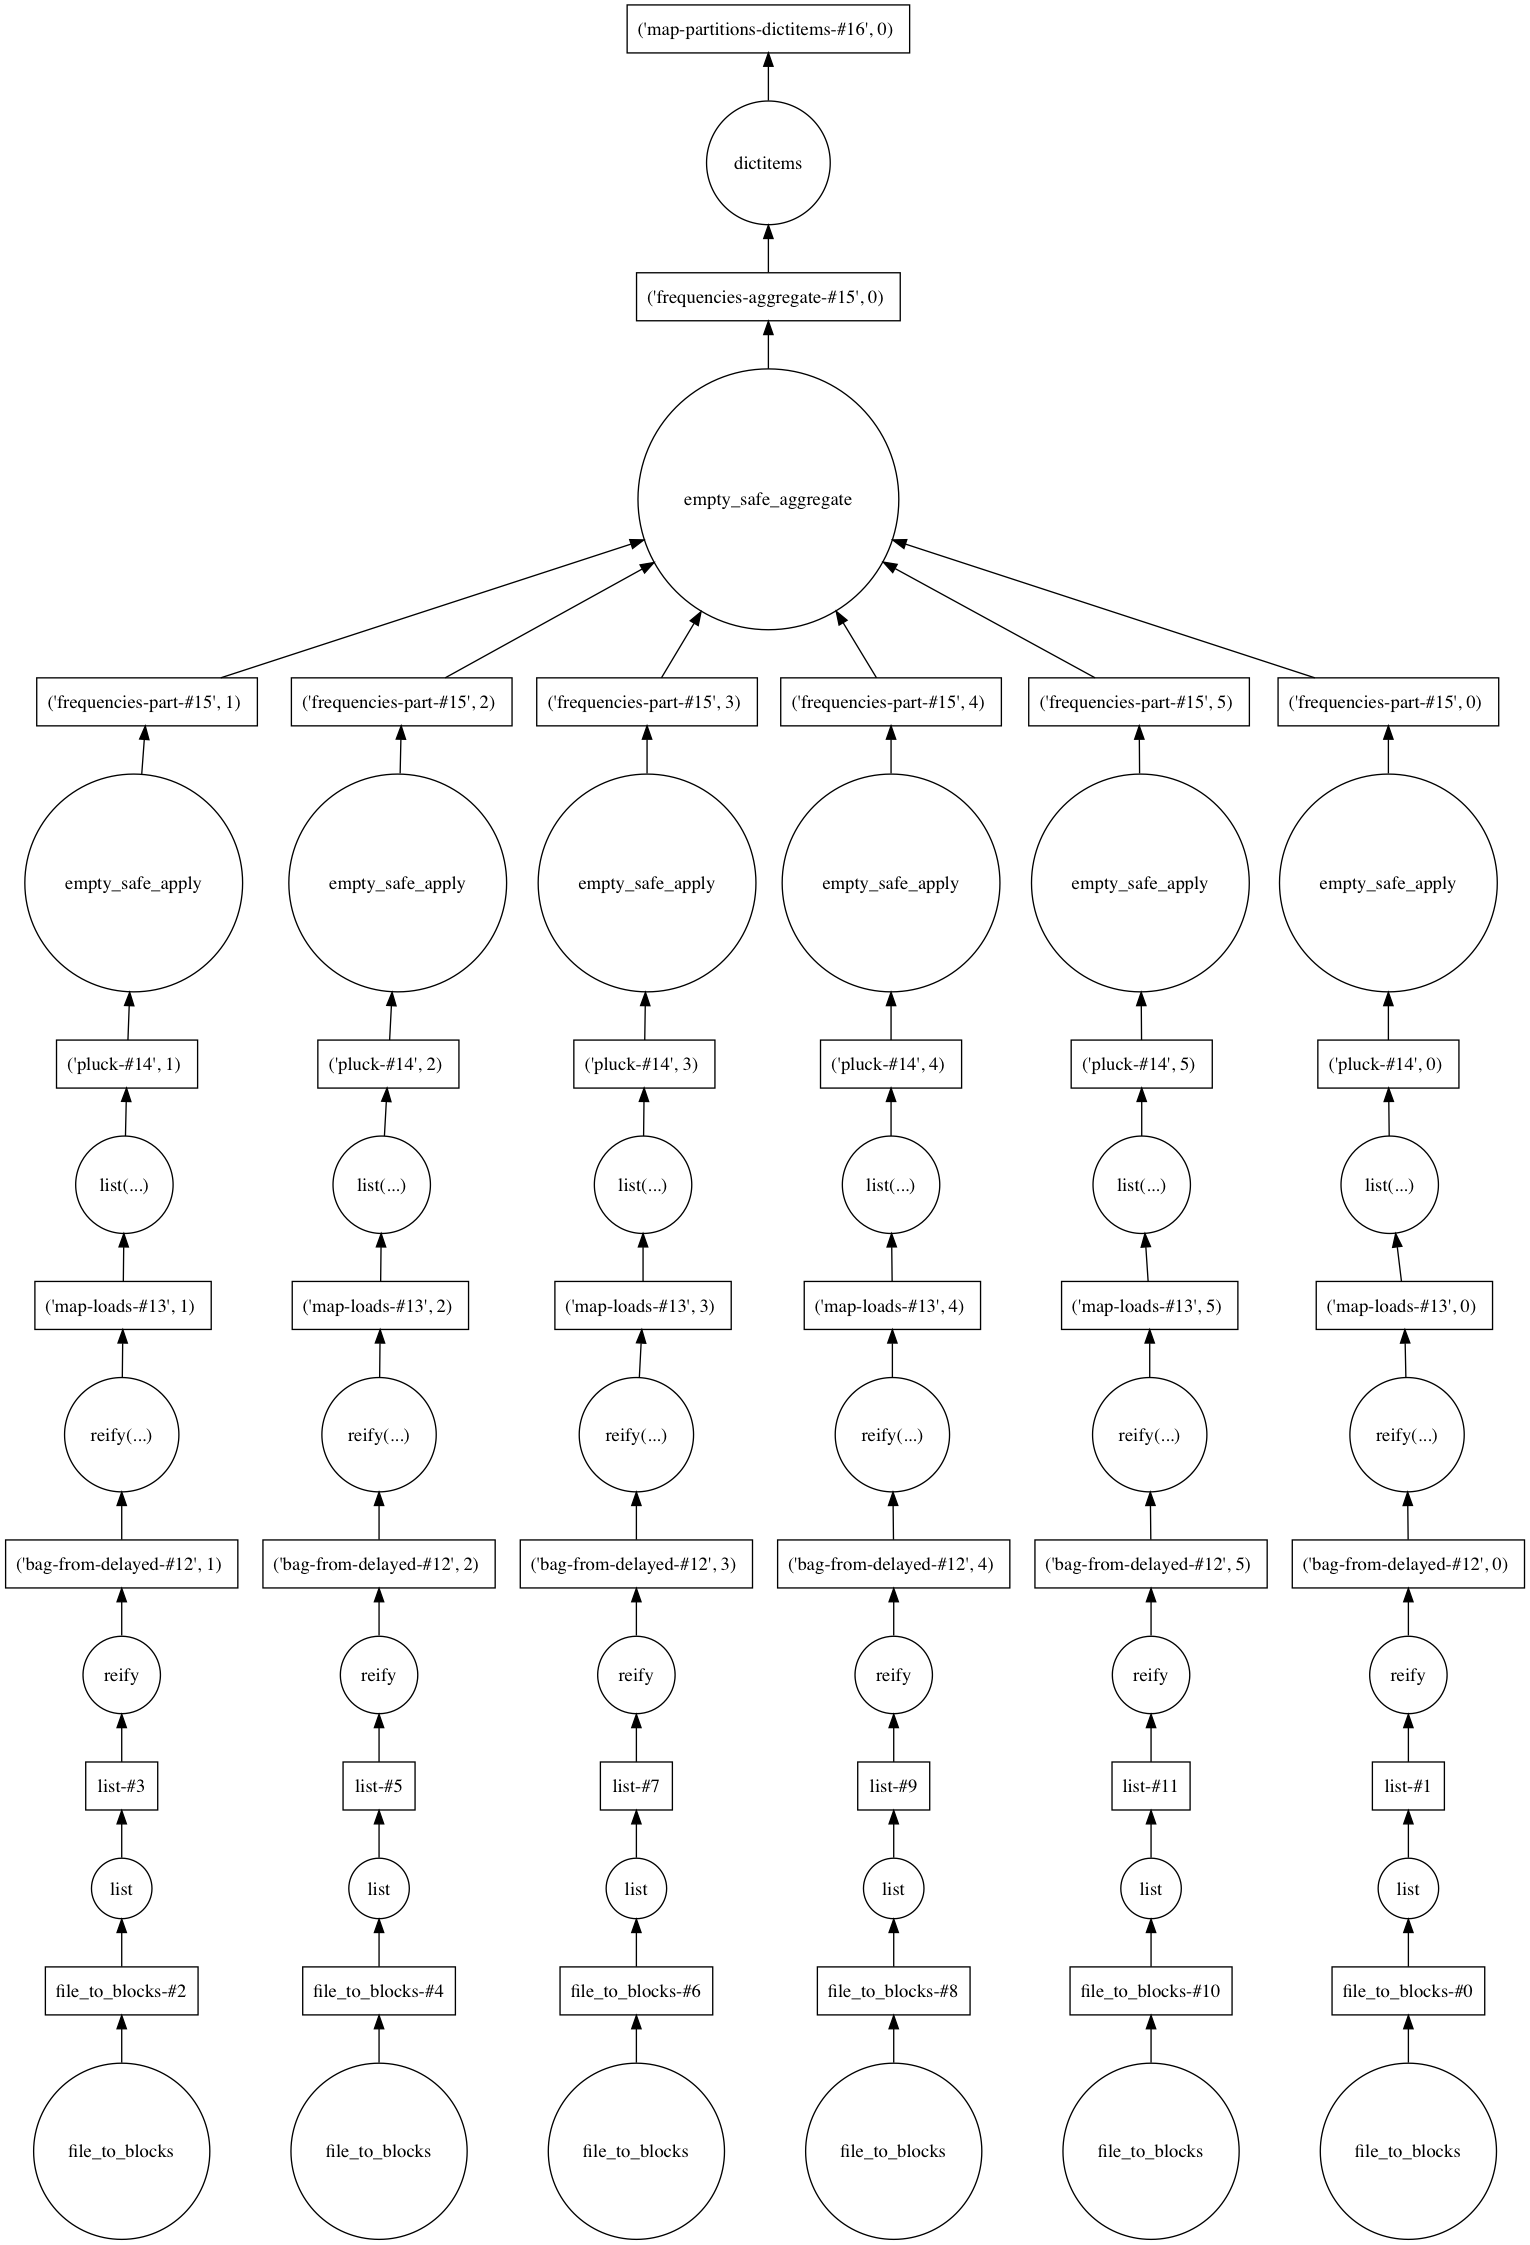

In [13]:
import dask

dask.visualize(bag, filename='bag.pdf')
dask.visualize(bag)

In [1]:
# Example from https://www.youtube.com/watch?v=N_GqzcuGLCY

import dask
from dask import array as da

x = da.random.random((100, 100, 10), chunks=(10, 10, 5))
y = da.random.random((100, 100, 10), chunks=(10, 10, 5))
z = (da.arcsin(x) - da.arccos(y)).sum(axis=(1, 2))

In [30]:
z._keys()

[('sum-aggregate-1a18d047801974749fc3278fbef8a136', 0),
 ('sum-aggregate-1a18d047801974749fc3278fbef8a136', 1),
 ('sum-aggregate-1a18d047801974749fc3278fbef8a136', 2),
 ('sum-aggregate-1a18d047801974749fc3278fbef8a136', 3),
 ('sum-aggregate-1a18d047801974749fc3278fbef8a136', 4),
 ('sum-aggregate-1a18d047801974749fc3278fbef8a136', 5),
 ('sum-aggregate-1a18d047801974749fc3278fbef8a136', 6),
 ('sum-aggregate-1a18d047801974749fc3278fbef8a136', 7),
 ('sum-aggregate-1a18d047801974749fc3278fbef8a136', 8),
 ('sum-aggregate-1a18d047801974749fc3278fbef8a136', 9)]

In [12]:
dask.visualize(z, filename='dask.pdf')

In [2]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:63538 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [3]:
# Example from https://www.youtube.com/watch?v=N_GqzcuGLCY

import dask
from dask import array as da

x = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
y = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
z = (da.arcsin(x) - da.arccos(y)).sum(axis=(1, 2))

In [5]:
result = z.compute()

distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.39s.  This is often caused by long-running GIL-holding functions or moving large chunks 

---

<center><h2>&#191;?&#191; QUESTIONS ?&#191;?</h2></center>

---

## A `dask` cluster that scales up and down based on compute load

- `adaptive`

---

<center><h2>!!! PROBLEMS AHEAD !!!</h2></center>

---

In [6]:
client.close()

In [7]:
from tornado import gen
from distributed import LocalCluster


class SomeCluster(LocalCluster):
    @gen.coroutine
    def scale_up(self, n, **kwargs):
        n_ = min(2, n)
        print(f'SCALING UP TO {n} ({n_}) WORKERS, HAS {len(self.scheduler.workers)}')
        super().scale_up(n_, **kwargs)
        
    @gen.coroutine
    def scale_down(self, workers):
        print(f'SHUTTING DOWN WORKERS {workers}')
#         raise NotImplementedError()

In [8]:
from distributed.deploy import Adaptive
from distributed import Scheduler

scheduler = Scheduler()
cluster = SomeCluster(n_workers=6, threads_per_worker=1, ncores=1)
adaptive_cluster = Adaptive(scheduler, cluster)
scheduler.start();

In [9]:
from dask.distributed import Client

client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:63671 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 12.88 GB


In [10]:
cluster.adapt();

SHUTTING DOWN WORKERS ['tcp://127.0.0.1:63696', 'tcp://127.0.0.1:63682', 'tcp://127.0.0.1:63690', 'tcp://127.0.0.1:63678', 'tcp://127.0.0.1:63694', 'tcp://127.0.0.1:63684']


In [11]:
# Example from https://www.youtube.com/watch?v=N_GqzcuGLCY

import dask
from dask import array as da

x = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
y = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
z = (da.arcsin(x) - da.arccos(y)).sum(axis=(1, 2))

In [12]:
result = client.compute(z)

SCALING UP TO 1 (1) WORKERS, HAS 0
SCALING UP TO 14 (2) WORKERS, HAS 1
SCALING UP TO 12 (2) WORKERS, HAS 2
SCALING UP TO 11 (2) WORKERS, HAS 2
SCALING UP TO 11 (2) WORKERS, HAS 2
SCALING UP TO 10 (2) WORKERS, HAS 2
SCALING UP TO 10 (2) WORKERS, HAS 2
SCALING UP TO 10 (2) WORKERS, HAS 2
SCALING UP TO 9 (2) WORKERS, HAS 2
SCALING UP TO 9 (2) WORKERS, HAS 2
SCALING UP TO 8 (2) WORKERS, HAS 2
SCALING UP TO 8 (2) WORKERS, HAS 2
SCALING UP TO 7 (2) WORKERS, HAS 2
SCALING UP TO 7 (2) WORKERS, HAS 2
SCALING UP TO 7 (2) WORKERS, HAS 2
SCALING UP TO 7 (2) WORKERS, HAS 2
SCALING UP TO 7 (2) WORKERS, HAS 2
SCALING UP TO 6 (2) WORKERS, HAS 2
SCALING UP TO 6 (2) WORKERS, HAS 2
SCALING UP TO 5 (2) WORKERS, HAS 2
SCALING UP TO 5 (2) WORKERS, HAS 2
SCALING UP TO 4 (2) WORKERS, HAS 2
SCALING UP TO 4 (2) WORKERS, HAS 2
SCALING UP TO 4 (2) WORKERS, HAS 2
SCALING UP TO 4 (2) WORKERS, HAS 2
SCALING UP TO 4 (2) WORKERS, HAS 2
SCALING UP TO 4 (2) WORKERS, HAS 2
SCALING UP TO 4 (2) WORKERS, HAS 2
SCALING UP TO

In [13]:
cluster.close()

---

In [ ]:
from dask.distributed import Adaptive

class CustomAdaptive(Adaptive):
    def get_scale_up_kwargs(self):
        kwargs = super(Adaptive, self).get_scale_up_kwargs()
        # resource_restrictions maps task keys to a dict of restrictions
        restrictions = self.scheduler.resource_restrictions.values()
        memory_restrictions = [x.get('memory') for x in restrictions
                               if 'memory' in x]

        if memory_restrictions:
            kwargs['memory'] = max(memory_restrictions)

        return kwargs

---

In [16]:
import random
import numpy as np
import time
import dask

def preprocess(a):
    time.sleep(random.randint(1, 5))
    return np.log2(a)

def compute_c(a, b):
    time.sleep(random.randint(1, 5))
    return b

def compute_d(b):
    time.sleep(random.randint(1, 5))
    return b

def cv(a, d):
    time.sleep(random.randint(1, 5))
    return d

def aggregate(*args):
    time.sleep(random.randint(1, 5))
    return args[0]

def compute_f(c, d):
    time.sleep(random.randint(1, 5))
    return c

def compute_g(c, d, f):
    time.sleep(random.randint(1, 5))
    return c

def final(*args):
    time.sleep(10)
    return 'all done!!'

In [15]:
import numpy as np

g = {'load_data': np.random.random(size=(15000, 100)),
     'preprocess': (preprocess, 'load_data'),
     'c': (compute_c, 'load_data', 'preprocess'),
     'd': (compute_d, 'preprocess'),
     'f': (compute_f, 'c', 'd'),
     'g': (compute_g, 'c', 'd', 'f'),
     'aggregate': tuple([aggregate] + [f'cv_{i:02d}' for i in range(25)]),
     'final': (final, 'preprocess', 'c', 'd', 'aggregate', 'f', 'g')}

for i in range(25):
    g[f'cv_{i:02d}'] = (cv, 'preprocess', 'c')

NameError: name 'preprocess' is not defined

distributed.core - WARNING - Event loop was unresponsive in Scheduler for 901.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


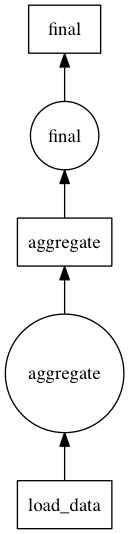

In [36]:
g = {'load_data': [np.random.random(size=(1500, 100)) for _ in range(10)],
     'aggregate': (aggregate, ['load_data', 'load_data', 'load_data']),
     'final': (final, 'aggregate')}

dask.visualize(g)

In [14]:
dask.visualize(g, filename='custom.pdf')

In [37]:
client.get(g, keys=['final'])

['all done!!']